## descriptive data exploration
* study the trending of correlation

### feature ranking
* correlation btw each feature and unit price
* random forest ranking


In [4]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

import logging
from utils import *
set_logger(logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
ds.update_views(materialize=True)

[dp] connect to database postgresql://postgres:@localhost:5432/sdra
[dp] supported views: ['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_transaction_valid']
[dp] execute c:\wenyan\dse_capstone\database\preprocess.sql
[dp] execute c:\wenyan\dse_capstone\database\materialize.sql


In [7]:
# load data from virtual view
#df_transaction = ds.get_view_df('property_address_transactions')
# load from materialized view
df_transaction = ds.get_view_df('property_transaction_valid')
df_property = ds.get_view_df('property_addresses')
pp = Preprocess(df_transaction, df_property)

### retrieve the dataset

In [8]:
df_all_valid = pp.dataset(valid=True)
print('all dataset', df_all_valid.shape)
# last year transactions of valid properties
df_last_year_valid = pp.dataset(valid=True, date=('2016-10-01', '2017-10-01'))
print('last year', df_last_year_valid.shape)

[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming date
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


all dataset (1444257, 23)


[dp] transforming view
[dp] transforming pool
[dp] transforming impr_over_land
[dp] transforming date
[dp] transforming sold_year
[dp] transforming sold_age
[dp] making sqft_zip_avg
[dp] making sqft_price_zip_avg
[dp] making sold_price_zip_avg
[dp] making sale_count_zip
[dp] making prop_count_zip


last year (37630, 23)


### correlation between features and target(sqft_price)
* with geography: street, zip, city
* with property characteristic: sqft, lot_size_sqft

In [9]:
df_all_valid[:3]

,zip,sale_count_zip,sqft_zip_avg,view,num_bed,sqft_price_zip_avg,year_built,acre,prop_count_zip,num_bath,...,sold_price,sqft,eval_land,date,sqft_price,sold_price_zip_avg,impr_over_land,sold_year,pool,eval_imps
0,91911,23854,1493.117884,0,3,156.568207,1955.0,0,13639,1,...,447000,1120,133145,2017-10-24,399,228727.329169,0.833332,2017,0,110954
1,91911,23854,1493.117884,1,3,156.568207,1956.0,0,13639,2,...,330000,1050,270000,2017-09-27,314,228727.329169,0.222222,2017,0,60000
2,91911,23854,1493.117884,0,3,156.568207,1959.0,0,13639,2,...,510000,1204,126061,2017-09-27,423,228727.329169,2.734137,2017,0,344668


In [10]:
features = set(pp.get_feature_list('all')) - set(['date', 'street', 'zip', 'sold_year', 'sqft_price']) # exclude features not suitable
#features -= set(['year_built'])   # features under work

In [22]:
df_last_year_valid.columns

Index(['zip', 'sale_count_zip', 'sqft_zip_avg', 'view', 'num_bed',
       'sqft_price_zip_avg', 'year_built', 'acre', 'prop_count_zip',
       'num_bath', 'street', 'sold_age', 'usable_sqft', 'sold_price', 'sqft',
       'eval_land', 'date', 'sqft_price', 'sold_price_zip_avg',
       'impr_over_land', 'sold_year', 'pool', 'eval_imps'],
      dtype='object')

In [24]:
df_transaction[:20][['str_no', 'street', 'st_type', 'city', 'zip', 'sold_price', 'sqft', 'usable_sqft', 'acre']]

,str_no,street,st_type,city,zip,sold_price,sqft,usable_sqft,acre
0,1113,HILLTOP,DR,CHULA VISTA,91911,447000,1120,7700.0,0
1,3305,GENOA,WAY,OCEANSIDE,92056,397000,1016,NaN,0
2,145,JAMUL,AVE,CHULA VISTA,91911,330000,1050,5200.0,0
3,12630,CARMEL COUNTRY,RD,SAN DIEGO,92130,540000,1191,0.0,0
4,708,RIOS,AVE,SOLANA BEACH,92075,2525000,2911,14400.0,0
5,4755,WILSON,AVE,SAN DIEGO,92116,540000,1500,NaN,0
6,4080,GOLDFINCH,ST,SAN DIEGO,92103,832000,1514,NaN,0
7,16274,AVENIDA VENUSTO,None,SAN DIEGO,92128,432000,1230,0.0,0
8,7647,MISSION GORGE,RD,SAN DIEGO,92120,345000,1035,0.0,0
9,190,BAUTISTA,CT,OCEANSIDE,92057,365000,1420,NaN,0


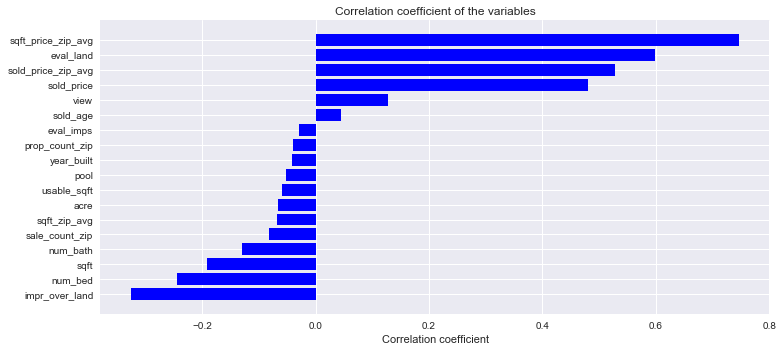

{'acre': -0.065600671717496728,
 'eval_imps': -0.028411076858141135,
 'eval_land': 0.59858109829329786,
 'impr_over_land': -0.32567459990104602,
 'num_bath': -0.1300833869898145,
 'num_bed': -0.24493193503091235,
 'pool': -0.051351021692486939,
 'prop_count_zip': -0.040170528871025284,
 'sale_count_zip': -0.082147948782174768,
 'sold_age': 0.045141833279138351,
 'sold_price': 0.4803509568930856,
 'sold_price_zip_avg': 0.52856079439604897,
 'sqft': -0.19122041370025217,
 'sqft_price_zip_avg': 0.74720391358099791,
 'sqft_zip_avg': -0.067860849052578359,
 'usable_sqft': -0.059025835909995071,
 'view': 0.12852586406924352,
 'year_built': -0.042216367184058405}

In [12]:
plot_correlation(df_last_year_valid, 'sqft_price', features)

### correlation matrix of delivered features

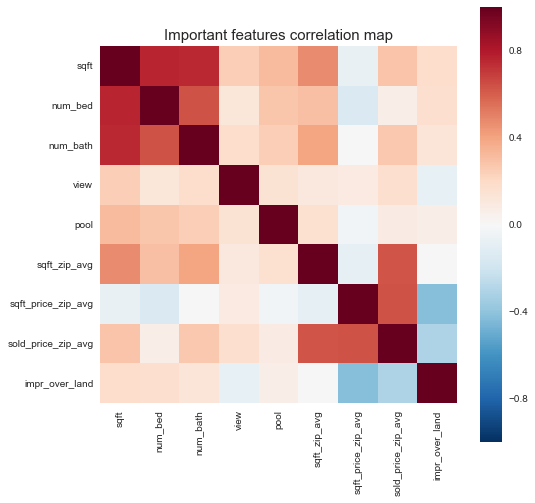

In [22]:
corr_features = list(features)
corr_features = pp.get_feature_list()
corrmat = df_last_year_valid[corr_features].corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important features correlation map", fontsize=15)
plt.show()